In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../..")
from ai4material_design.scripts.summary_table_lean import read_trial
from ai4material_design.ai4mat.data.data import StorageResolver

In [65]:
targets = ["formation_energy_per_site"]
results = []
with open("../scripts/ASPIRE-1/MoS2_V2_E.txt", "rt") as definitions_file:
    for line in definitions_file:
        trial, target, n_repeats, _, experiment = line.strip().split()
        for i in range(1, int(n_repeats) + 1):
            these_results = read_trial(experiment, f"stability/{trial}/{i}", True, targets, True)
            these_results["trial_family"] = trial
            these_results["trial_index"] = i
            results.append(these_results)
high_to_V2_trial = "megnet_pytorch/sparse/d6b7ce45_no_resample"
these_results = read_trial("MoS2_high_to_V2", high_to_V2_trial, True, ["formation_energy_per_site"], True)
these_results["trial_family"] = "high_to_V2"
these_results["trial_index"] = 1
results.append(these_results)

In [66]:
results_pd = pd.concat(results, axis=0)

In [67]:
folded_predictions = results_pd.loc[
    ("formation_energy_per_site", "combined"),
    ("trial_family", "trial_index", "predictions")].set_index(
        ["trial_family", "trial_index"]).squeeze()

/tmp/ipykernel_73712/2301786316.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  folded_predictions = results_pd.loc[


In [68]:
predictions_list = []
for (trail_family, trial_index), these_predictions in folded_predictions.items():
    prediction_frame = these_predictions.to_frame()
    prediction_frame["trial_family"] = trail_family
    prediction_frame["trial_index"] = trial_index
    prediction_frame.set_index(["trial_family", "trial_index", prediction_frame.index], inplace=True)
    predictions_list.append(prediction_frame.squeeze())

In [69]:
predictions_pd = pd.concat(predictions_list, axis=0)

In [70]:
structures = pd.read_pickle(StorageResolver()["processed"]/"low_density_defects/MoS2/data.pickle.gz").reindex(predictions_pd.index.get_level_values('_id').unique())

In [71]:
from operator import methodcaller
distances = structures.defect_representation.apply(methodcaller("get_distance", 0, 1))

In [72]:
true_energies = structures.formation_energy_per_site

In [73]:
distance_order = distances.argsort()

In [85]:
labels = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet, tuned",
    "schnet/base": "SchNet, default",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost, tuned",
    "catboost/base": "CatBoost, default",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet, tuned",
    "gemnet/base": "GemNet, default",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full), tuned",
    'megnet_pytorch/full/base': "MegNet (full), default",
    "high_to_V2": "Tuned MegNet (sparse),\ntrained on high-density MoS$_2$ only"
}

In [86]:
predictions_pd.index.get_level_values("trial_family").unique()

Index(['schnet/25-11-2022_16-52-31/71debf15', 'schnet/base',
       'catboost/29-11-2022_13-16-01/02e5eda9', 'catboost/base',
       'gemnet/16-11-2022_20-05-04/b5723f85',
       'megnet_pytorch/25-11-2022_11-38-18/1baefba7',
       'megnet_pytorch/full/base', 'high_to_V2'],
      dtype='object', name='trial_family')

/home/users/nus/kna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/users/nus/kna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


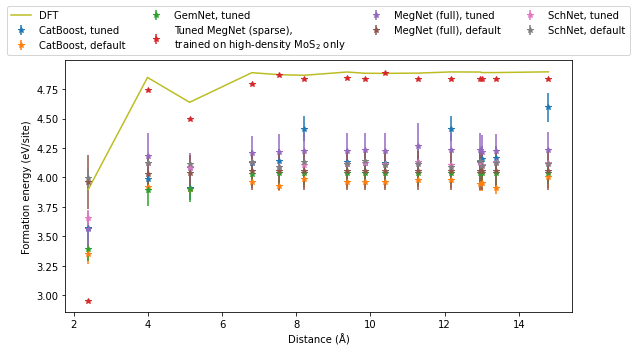

In [88]:
fig, ax = plt.subplots(figsize=(9, 5))
for trial_family, family_predictions in predictions_pd.groupby(level="trial_family"):
    prediction_mean = family_predictions.groupby(level="_id").mean()
    prediction_std = family_predictions.groupby(level="_id").std()
    ax.errorbar(distances, prediction_mean, yerr=prediction_std, label=labels[trial_family], fmt="*")
ax.plot(distances[distance_order], true_energies[distance_order], label="DFT")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4)
ax.set_xlabel("Distance (Å)")
ax.set_ylabel("Formation energy (eV/site)")
plt.tight_layout()
fig.savefig("MoS2_V2.png", dpi=300)